In [1]:
import pandas as pd
import numpy
import numpy as np
import matplotlib.pylab as plt
#%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,4.8
import math
from sklearn.preprocessing import MinMaxScaler
#15, 6
import matplotlib.pyplot as plt
import time
#import statsmodels
#from statsmodels.tsa.stattools import adfuller
#import statsmodels.api as sm
import scipy
from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import mutual_info_score

In [3]:
loaded = np.load('/home/caducovas/recEnergy_N1-AE_20_20.npz')


In [6]:
loaded.keys()
#loaded['iEnergy'].shape,loaded['rEnergy'].shape

['iEnergy', 'rEnergy']

In [11]:
loaded['iEnergy'][0].shape,loaded['iEnergy'][1].shape

((13532, 100), (9301, 100))

In [12]:
#b,r = loaded['iEnergy'],loaded['rEnergy']
sgn,bkg = loaded['iEnergy'][0],loaded['iEnergy'][1]

In [13]:
def calc_MI2(x, y):
    max_value = max(max(x),max(y))
    min_value = min(min(x),min(y))
    bins = min( len(np.histogram(x,'fd')[0]), len(np.histogram(y,'fd')[0]))
    bins_list = np.linspace(min_value, max_value, num=bins)
    c_xy,xaaa,yaaa = np.histogram2d(x, y, bins=(bins_list,bins_list))
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi #,xaaa,yaaa,bins

In [14]:
def calc_kl(x, y):
    from scipy import stats
    max_value = max(max(x),max(y))
    min_value = min(min(x),min(y))
    bins = min( len(np.histogram(x,'fd')[0]), len(np.histogram(y,'fd')[0]))
    bins_list = np.linspace(min_value, max_value, num=bins)
    p,phist_bins=np.histogram(x,bins_list)
    q,qhist_bins=np.histogram(y,bins_list)
    #print(len(p),len(q))
    kl = stats.entropy(pk=p+0.00001, qk=q+0.00001)
    return kl

In [15]:
def calc_chisquare(x, y):
    from scipy import stats
    max_value = max(max(x),max(y))
    min_value = min(min(x),min(y))
    bins = min( len(np.histogram(x,'fd')[0]), len(np.histogram(y,'fd')[0]))
    bins_list = np.linspace(min_value, max_value, num=bins)
    p,phist_bins=np.histogram(x,bins_list)
    q,qhist_bins=np.histogram(y,bins_list)
    #print(len(p),len(q))
    chi = stats.chisquare(q+0.00001, p+0.00001)
    return chi

In [16]:
def mutualInformation_matrix(signal,measure='MI',sklearn=True,kde=False, n_bins=None):
    from statsmodels.sandbox.distributions.mv_measures import mutualinfo_kde, mutualinfo_binned
    print signal.shape
    cols,rows = signal.shape
    mat = np.zeros((rows, rows))
    #np.fill_diagonal(mat, 100)
    # Upper diagonal
    for r in range(rows):
        for c in range(r, rows):
            #print r,c
            #if r == c:
            #    continue

            if sklearn:
                try:
                    if measure == 'MI':
                        rr = calc_MI2(signal[:,r]+ 1e-12,signal[:,c]+ 1e-12)
                        score = round(np.sqrt(1. - np.exp(-2 * rr)),4)
                    elif measure == 'KL':
                        score = calc_kl(signal[:,r]+ 1e-12,signal[:,c]+ 1e-12)
                except:
                    score=None
            else:
                if n_bins is None:
                    p_bins = len(np.histogram(p, bins='fd')[0])
                    q_bins = len(np.histogram(q, bins='fd')[0])
                    n_bins = min(p_bins, q_bins)
                elif n_bins == 'auto':
                    qs = np.sort(q)
                    ps = np.sort(p)
                    qbin_sqr = np.sqrt(5./cols)
                    quantiles = np.linspace(0, 1, 1./qbin_sqr)
                    quantile_index = ((cols-1)*quantiles).astype(int)
                    #move edges so that they don't coincide with an observation
                    shift = 1e-6 + np.ones(quantiles.shape)
                    shift[0] -= 2*1e-6
                    q_bins = qs[quantile_index] + shift
                    p_bins = ps[quantile_index] + shift
                    n_bins = min(p_bins, q_bins)

                #mi = mutualinfo_binned(p, q, n_bins)[0]
                
                fx, binsx = np.histogram(p, bins = p_bins)
                fy, binsy = np.histogram(q, bins = q_bins)
                fyx, binsy, binsx = np.histogram2d(q, p, bins = (binsy, binsx))

                pyx = fyx * 1. / cols
                px = fx * 1. / cols
                py = fy * 1. / cols


                mi_obs = pyx * (np.log(pyx + 1e-12) - np.log(py + 1e-12)[:,None] - np.log(px + 1e-12))
                mi_obs[np.isnan(mi_obs)] = 0
                mi_obs[np.isinf(mi_obs)] = 0
                score = mi_obs.sum()
            import math
            #print mi
            #if math.isnan(float(mi)):
            #    mi = 100
            #elif mi > 1:
            #    mi = 1
            mat[r][c] = score
            mat[c][r] = score
    #print mat
    return mat

def plot_MutualInformation(mixtures=None,reconstruction=None,measure='MI',sae=None,plot_corr=False , KDE = False, nbins = None):
    import seaborn as sb
    
    if reconstruction is None:
        if plot_corr:
            fig, axs = plt.subplots(1,2, figsize=(40, 18))
        else:
            fig, axs = plt.subplots(figsize=(24, 18))
    else:
        if plot_corr:
            fig, axs = plt.subplots(2,2, figsize=(36, 18))
        else:
            fig, axs = plt.subplots(1,2, figsize=(40, 18))    

    if measure == 'KL':
        mat = mutualInformation_matrix(mixtures,measure='KL')
        minval=min(mat.flatten())
        maxval=max(mat.flatten())
    else:
        minval=0
        maxval=1
    if reconstruction is None:
        if plot_corr:
            sb.heatmap(mutualInformation_matrix(mixtures,measure=measure, kde=KDE, n_bins = nbins), ax=axs[0], annot=False, cmap = 'YlGnBu', vmin = minval, vmax = maxval)
            axs[0].set_title('Mutual Information',fontsize=20)
            #axs[0].set_tick_params(labelsize=20)

            sb.heatmap(np.abs(np.corrcoef(mixtures.T)), annot=False, cmap = 'YlOrRd', ax = axs[1], vmin = 0, vmax =  1)
            axs[1].set_title('Abs Correlation matrix',fontsize=20)
            #axs[1].set_tick_params(labelsize=20)
        else:
            sb.heatmap(mutualInformation_matrix(mixtures,measure=measure, kde=KDE, n_bins = nbins), annot=False, cmap = 'YlGnBu',  vmin = minval, vmax = maxval)
            axs.set_title('Mutual Information',fontsize=20)
    else:
        if plot_corr:
            sb.heatmap(mutualInformation_matrix(mixtures,measure=measure, kde=KDE, n_bins = nbins), ax=axs[0,0], annot=False, cmap = 'YlGnBu',  vmin = minval, vmax = maxval)
            axs[0,0].set_title('Signal Mutual Information')

            sb.heatmap(np.abs(np.corrcoef(mixtures.T)), annot=False, cmap = 'YlOrRd', ax = axs[0,1], vmin = 0, vmax =  1)
            axs[0,1].set_title('Signal Abs Correlation matrix')
            
            sb.heatmap(mutualInformation_matrix(reconstruction,measure=measure, kde=KDE, n_bins = nbins), ax=axs[1,0], annot=False, cmap = 'YlGnBu',  vmin = minval, vmax = maxval)
            axs[1,0].set_title('Reconstruction Mutual Information')

            sb.heatmap(np.abs(np.corrcoef(reconstruction.T)), annot=False, cmap = 'YlOrRd', ax = axs[1,1], vmin = 0, vmax =  1)
            axs[1,1].set_title('Reconstruction Abs Correlation matrix')

        else:
            sb.heatmap(mutualInformation_matrix(mixtures,measure=measure, kde=KDE, n_bins = nbins),ax=axs[0] , annot=False, cmap = 'YlGnBu',  vmin = minval, vmax = maxval)
            axs[0].set_title('Signal Mutual Information')
            
            sb.heatmap(mutualInformation_matrix(reconstruction,measure=measure, kde=KDE, n_bins = nbins),ax=axs[1] , annot=False, cmap = 'YlGnBu',  vmin = minval, vmax = maxval)
            axs[1].set_title('Reconstruction Mutual Information')

        
            
    return fig,axs

In [40]:
import scipy.stats
from sklearn.metrics import mean_squared_error
im=[]
kl=[]
chi=[]
corr=[]
mse=[]
for rings in range(100):
    try:
        #rr = calc_MI2(b[:,rings],r[:,rings])
        #mi_score = 100*round(np.sqrt(1. - np.exp(-2 * rr)),4)
        kl_score = calc_kl(sgn[:,rings],bkg[:,rings])
        #chi_score,chi_pvalue =calc_chisquare(b[:,rings],r[:,rings])
        #corr_score,corr_pvalue= scipy.stats.pearsonr(b[:,rings],r[:,rings])
        mean_squared_error(sgn[:bkg.shape[0],rings],bkg[:,rings])
        rr = calc_MI2(sgn[:bkg.shape[0],rings],bkg[:,rings])
        mi_score = 100*round(np.sqrt(1. - np.exp(-2 * rr)),4)
        #chi_score,chi_pvalue =calc_chisquare(b[:,rings],r[:,rings])
        corr_score,corr_pvalue= scipy.stats.pearsonr(sgn[:bkg.shape[0],rings],bkg[:,rings])

        im.append(mi_score)
        kl.append(kl_score)
        #chi.append(chi_score)
        corr.append(corr_score)
    except:
        im.append(None)
        kl.append(None)
        #chi.append(None)
        corr.append(None)

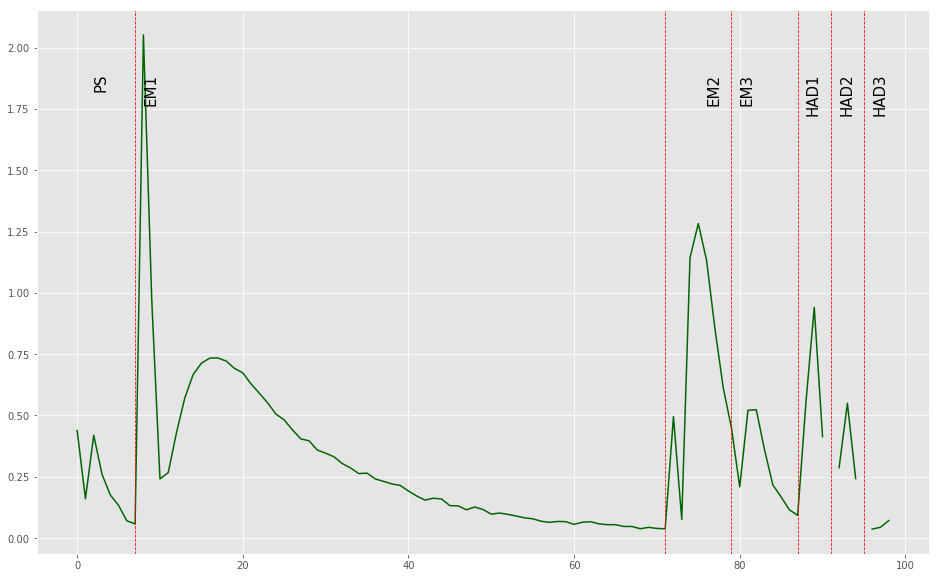

In [51]:
fig, ax = plt.subplots(figsize=(16,10))

plt.style.use('ggplot')

plt.plot(kl,color='darkgreen')
#ax2=ax.twinx()
#ax2.plot(corr,color='darkblue')

y_position = .9*max(kl) #*np.max([np.mean(sgn_KL, axis=0), np.mean(bkg_KL, axis=0)])
for i in [7, 71, 79, 87, 91, 95]:
    ax.axvline(i, color='red', linestyle='--', linewidth=.8)
for x,y,text in [(2,y_position,r'PS'), (8,y_position,r'EM1'),
                 (76,y_position,r'EM2'),(80,y_position,r'EM3'),
                 (88,y_position,r'HAD1'), (92,y_position,r'HAD2'), (96,y_position,r'HAD3'),]:
    ax.text(x,y,text, fontsize=15, rotation=90)
#fig.grid()


In [20]:
kl.index(max(kl))

8

(22833, 100)


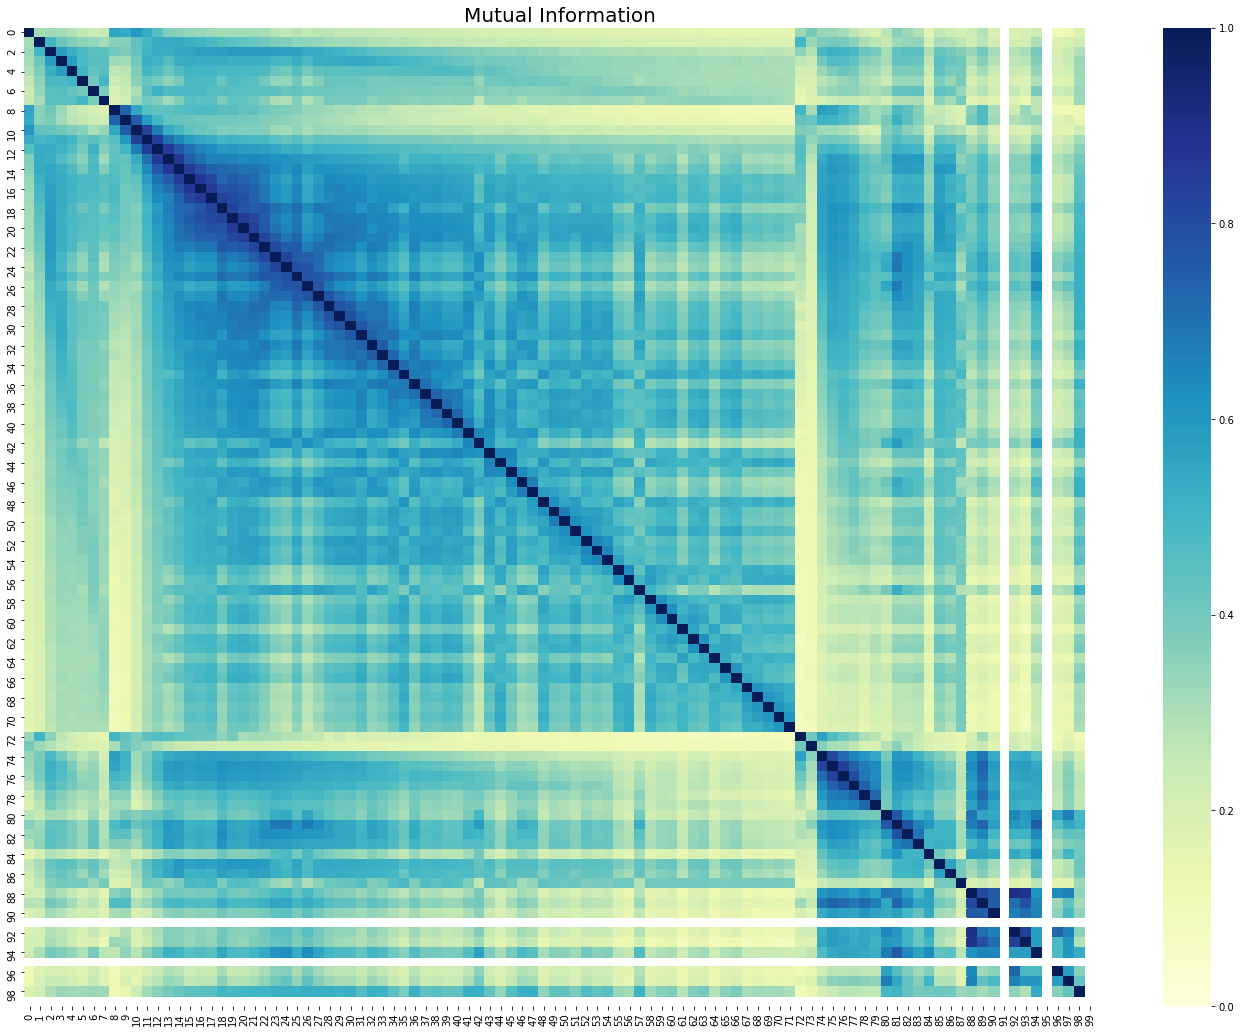

In [10]:
plot_MutualInformation(b,plot_corr=False)

(22833, 100)


/home/caducovas/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/caducovas/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


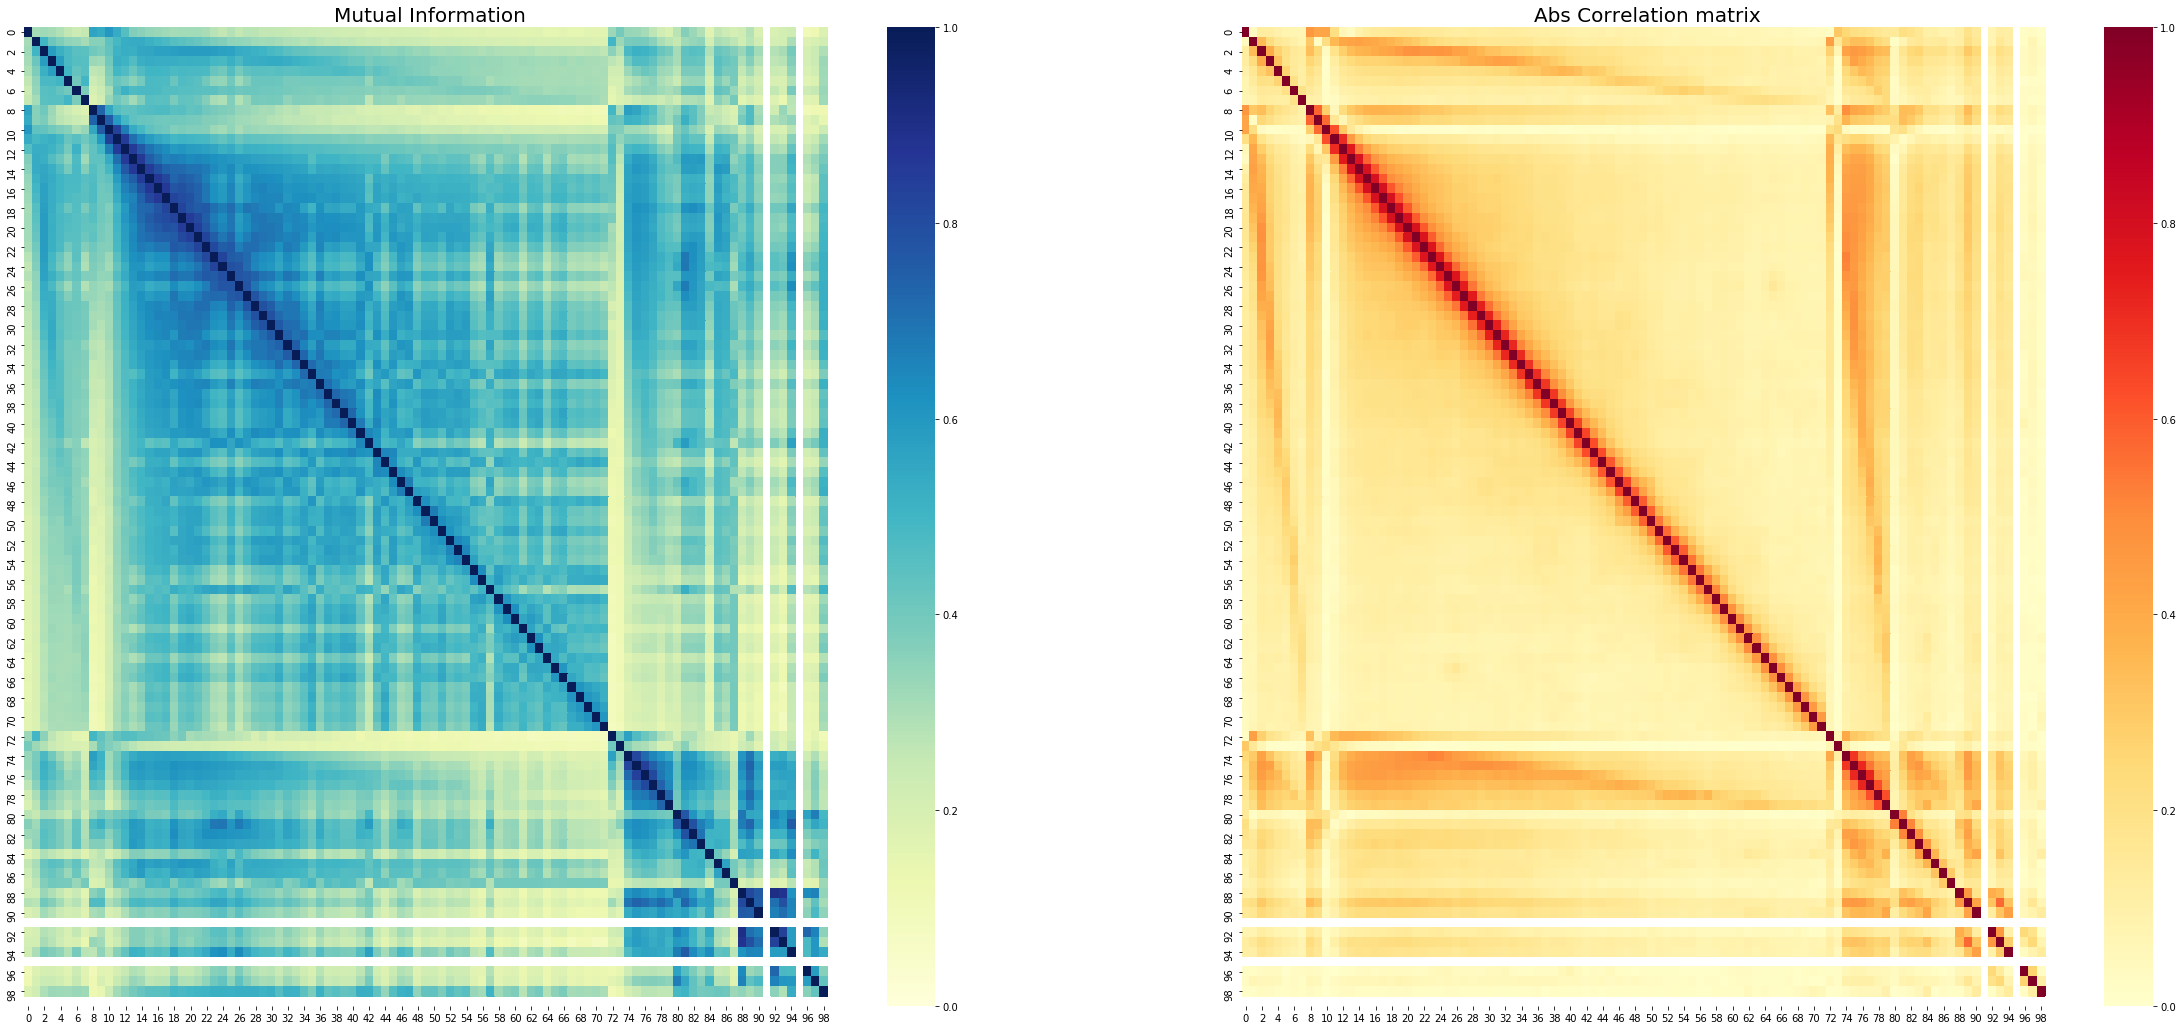

In [11]:
plot_MutualInformation(b,plot_corr=True)

(22833, 100)
(22833, 100)


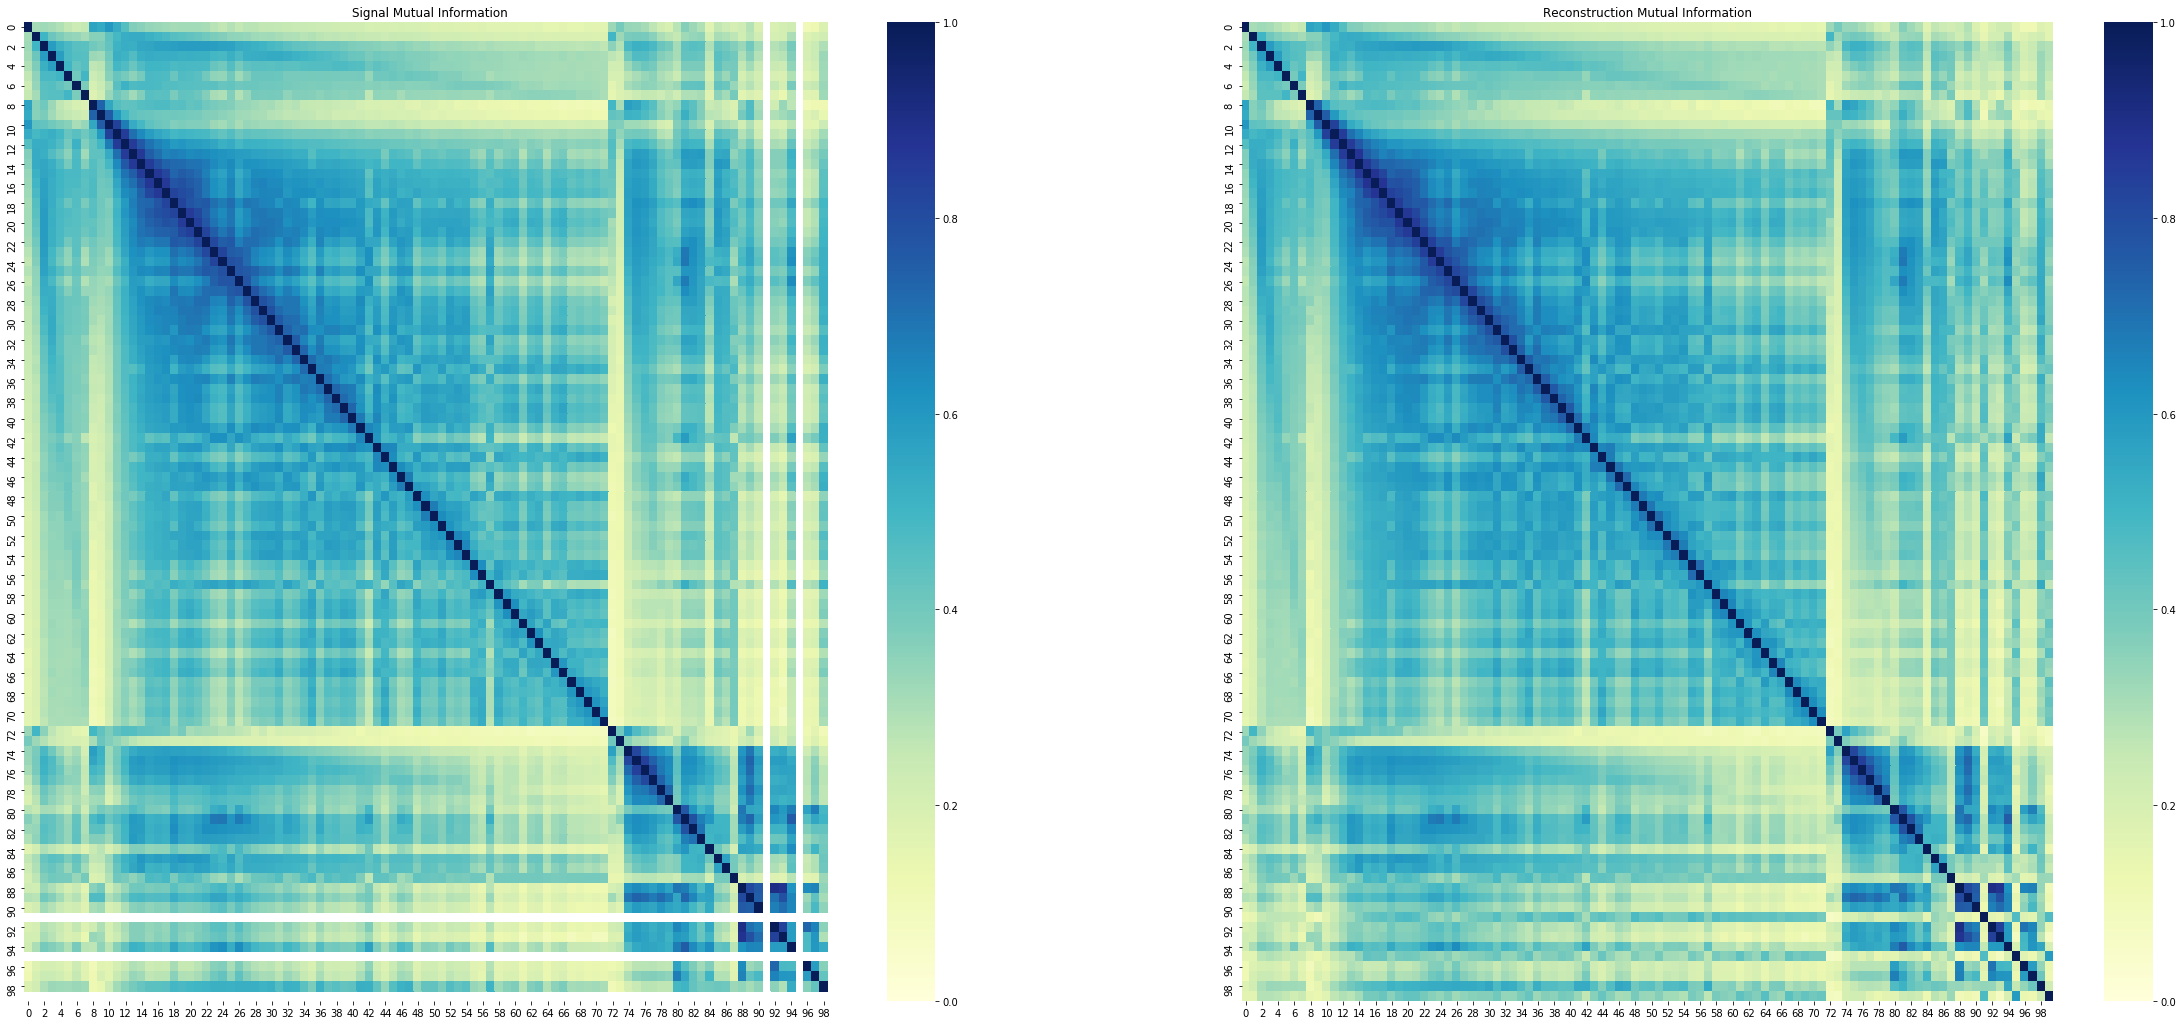

In [12]:
plot_MutualInformation(b,r,plot_corr=False)

(22833, 100)
(22833, 100)


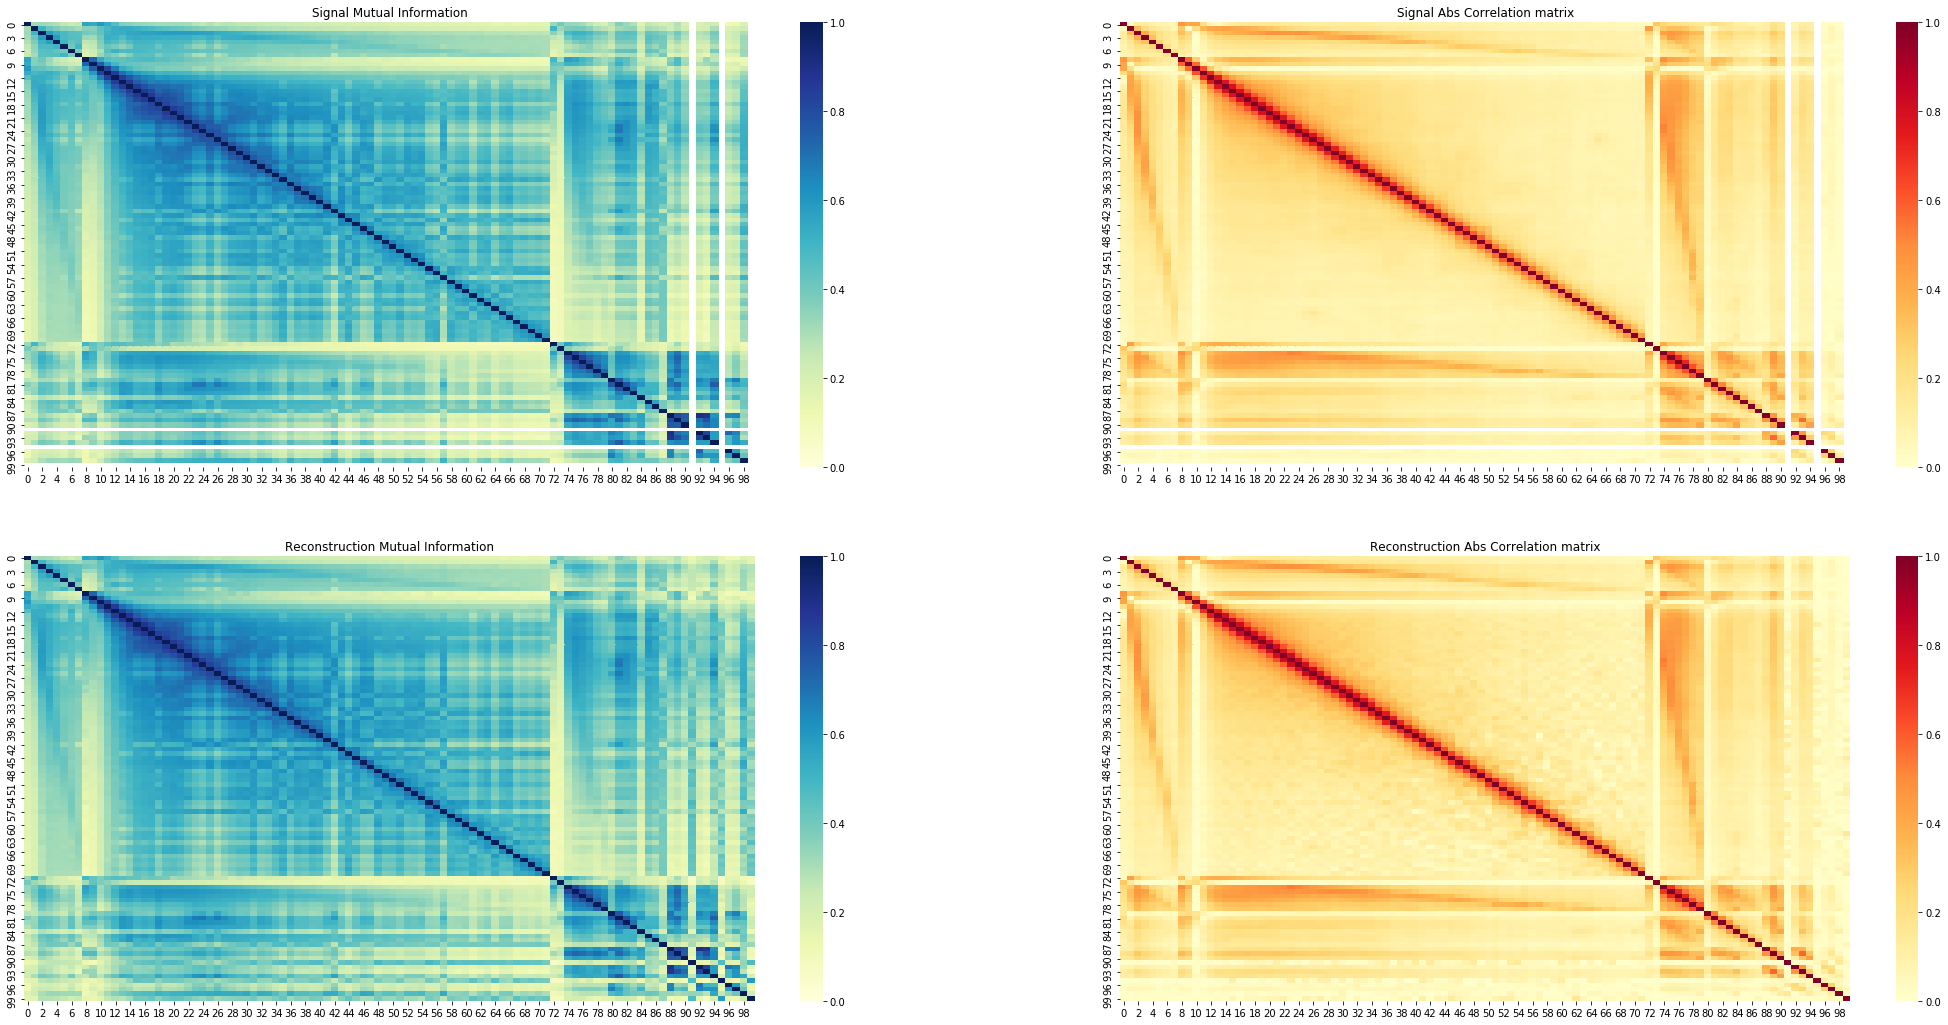

In [13]:
plot_MutualInformation(b,r,plot_corr=True)

In [14]:
plt.show()

(22833, 100)
(22833, 100)


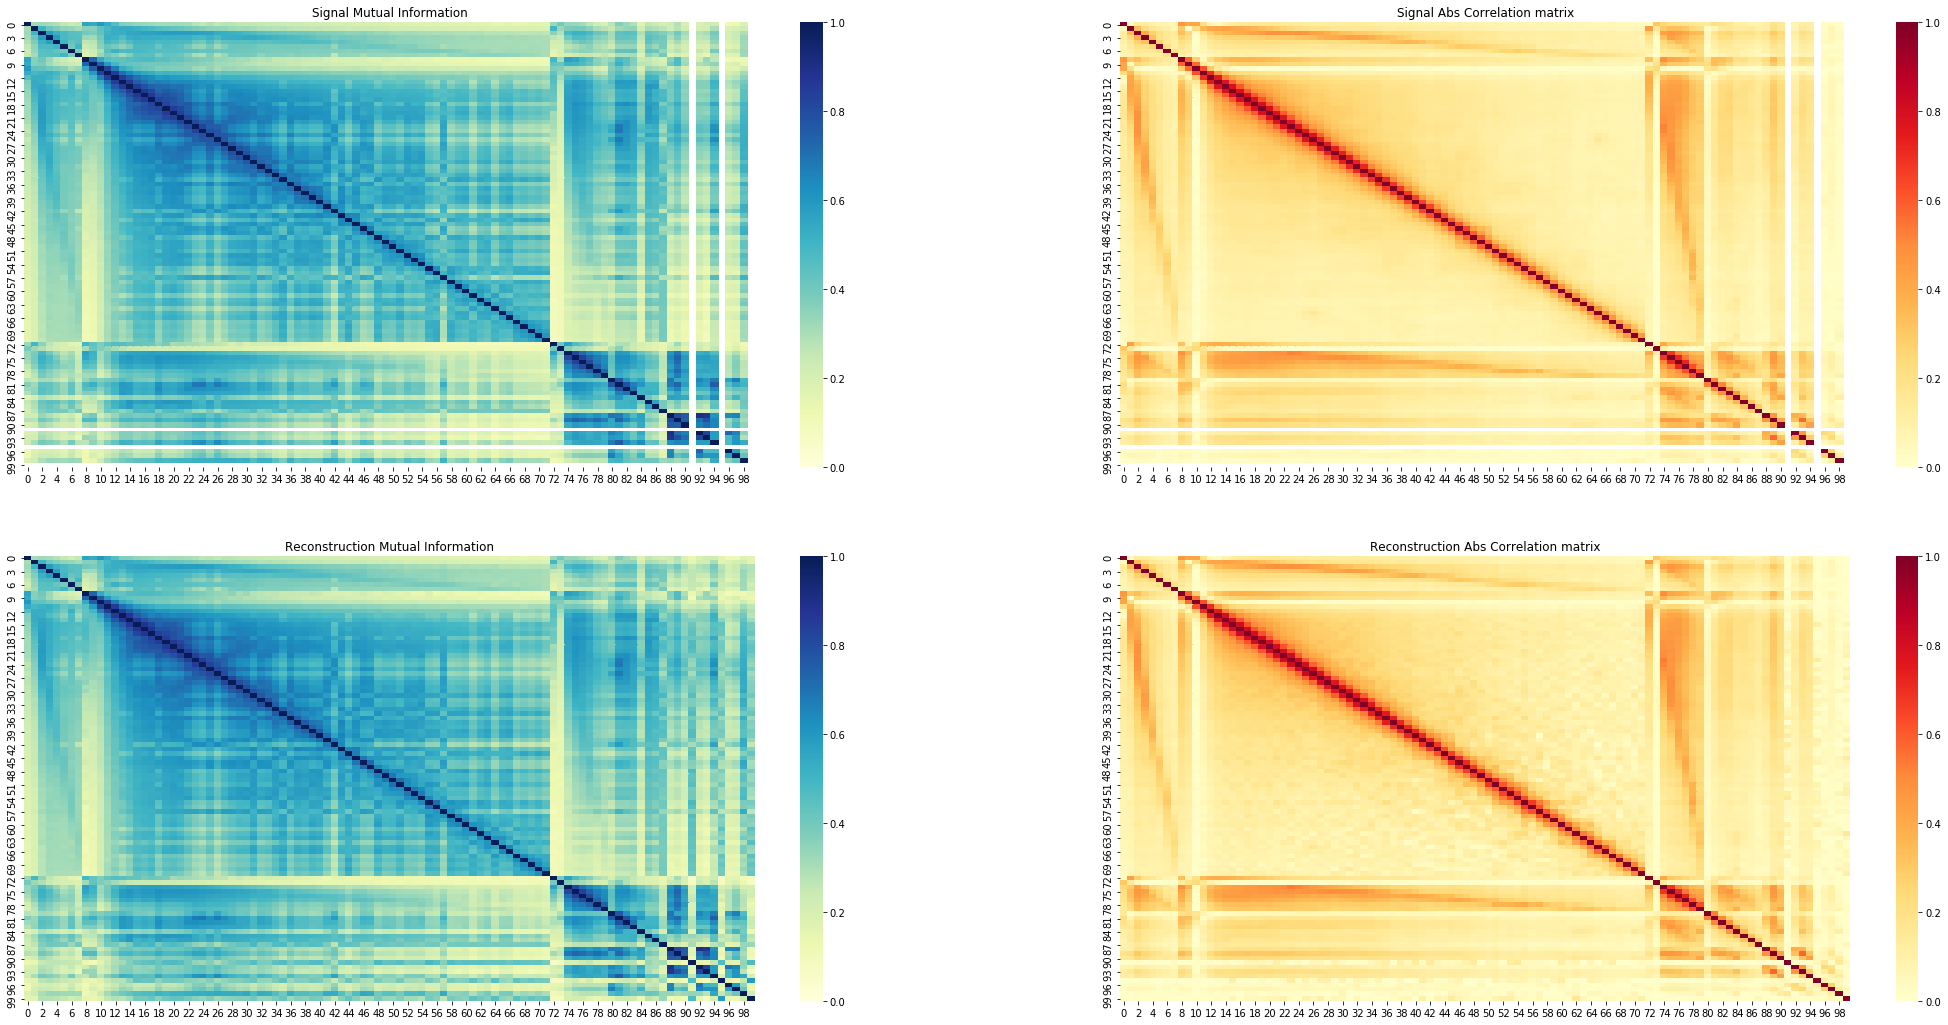

In [21]:
fig,axs = plot_MutualInformation(b,r,plot_corr=True)

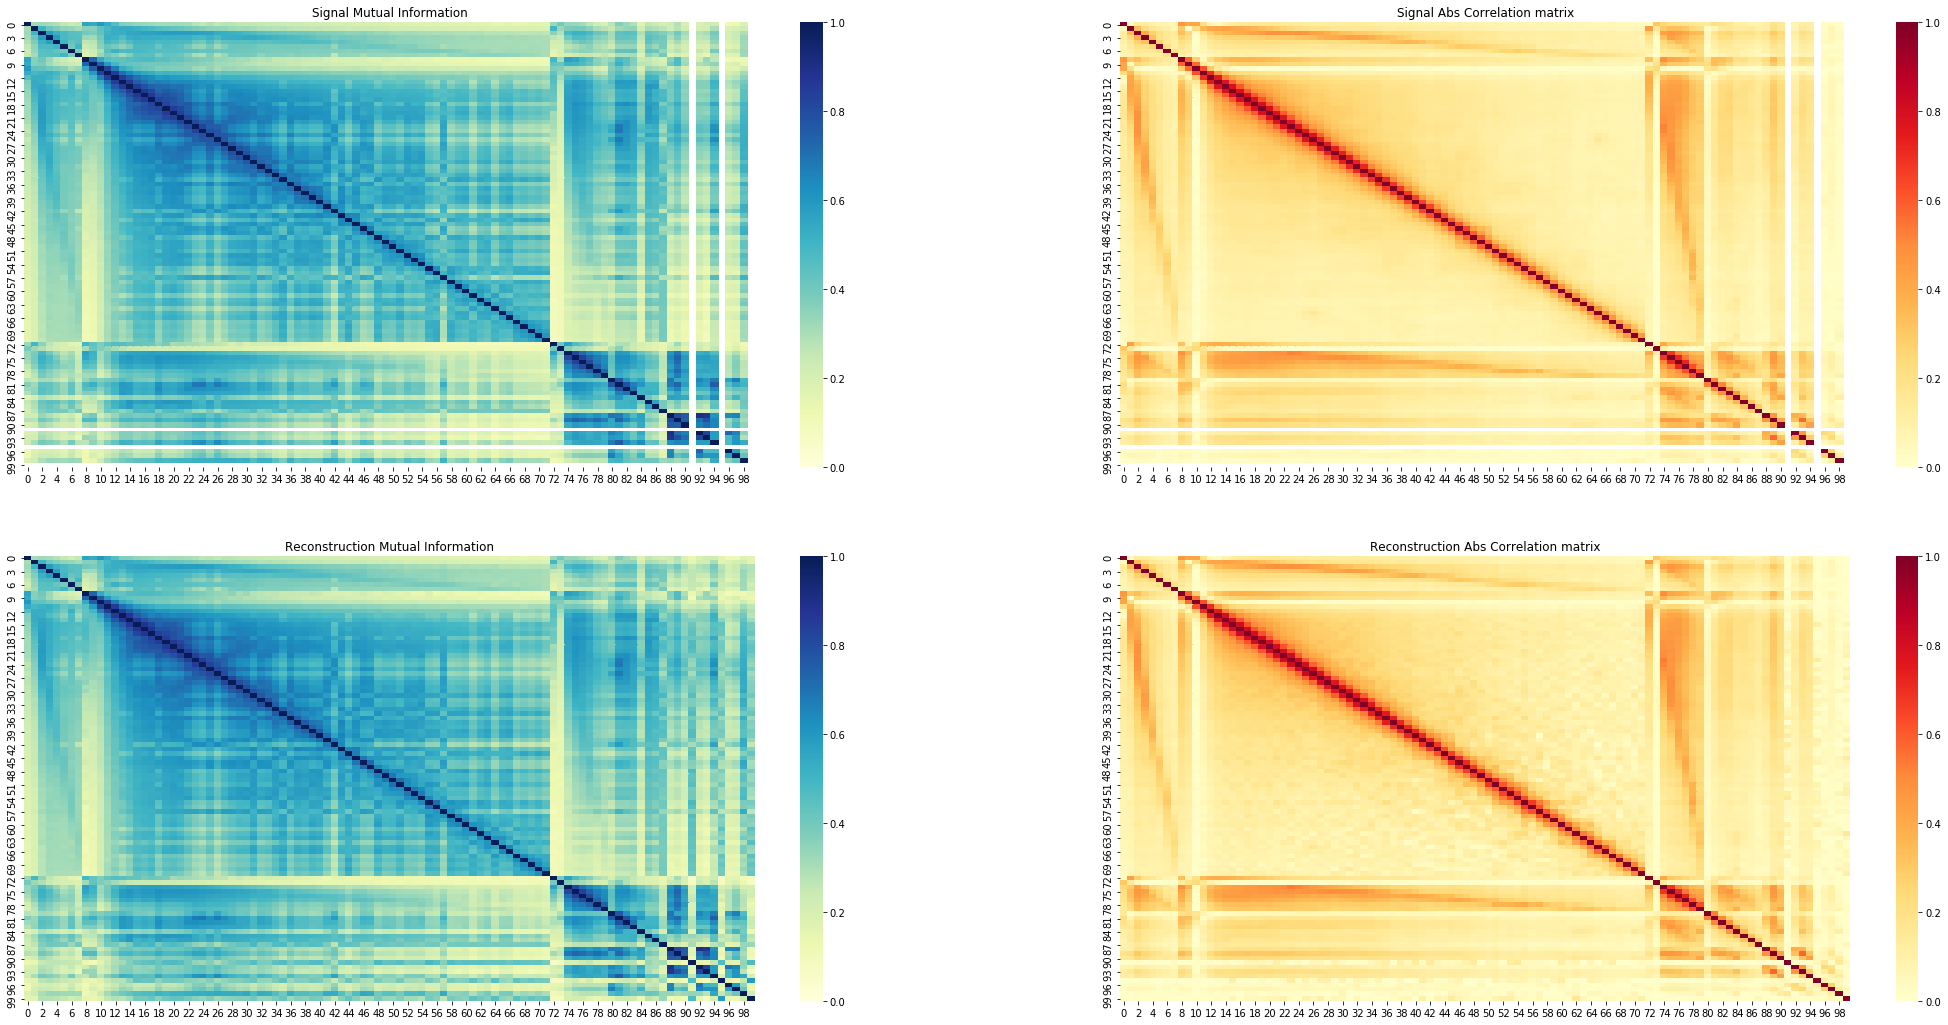

In [22]:
fig

In [28]:
fig.suptitle('This is the figure title', fontsize=20)

Text(0.5,0.98,'This is the figure title')

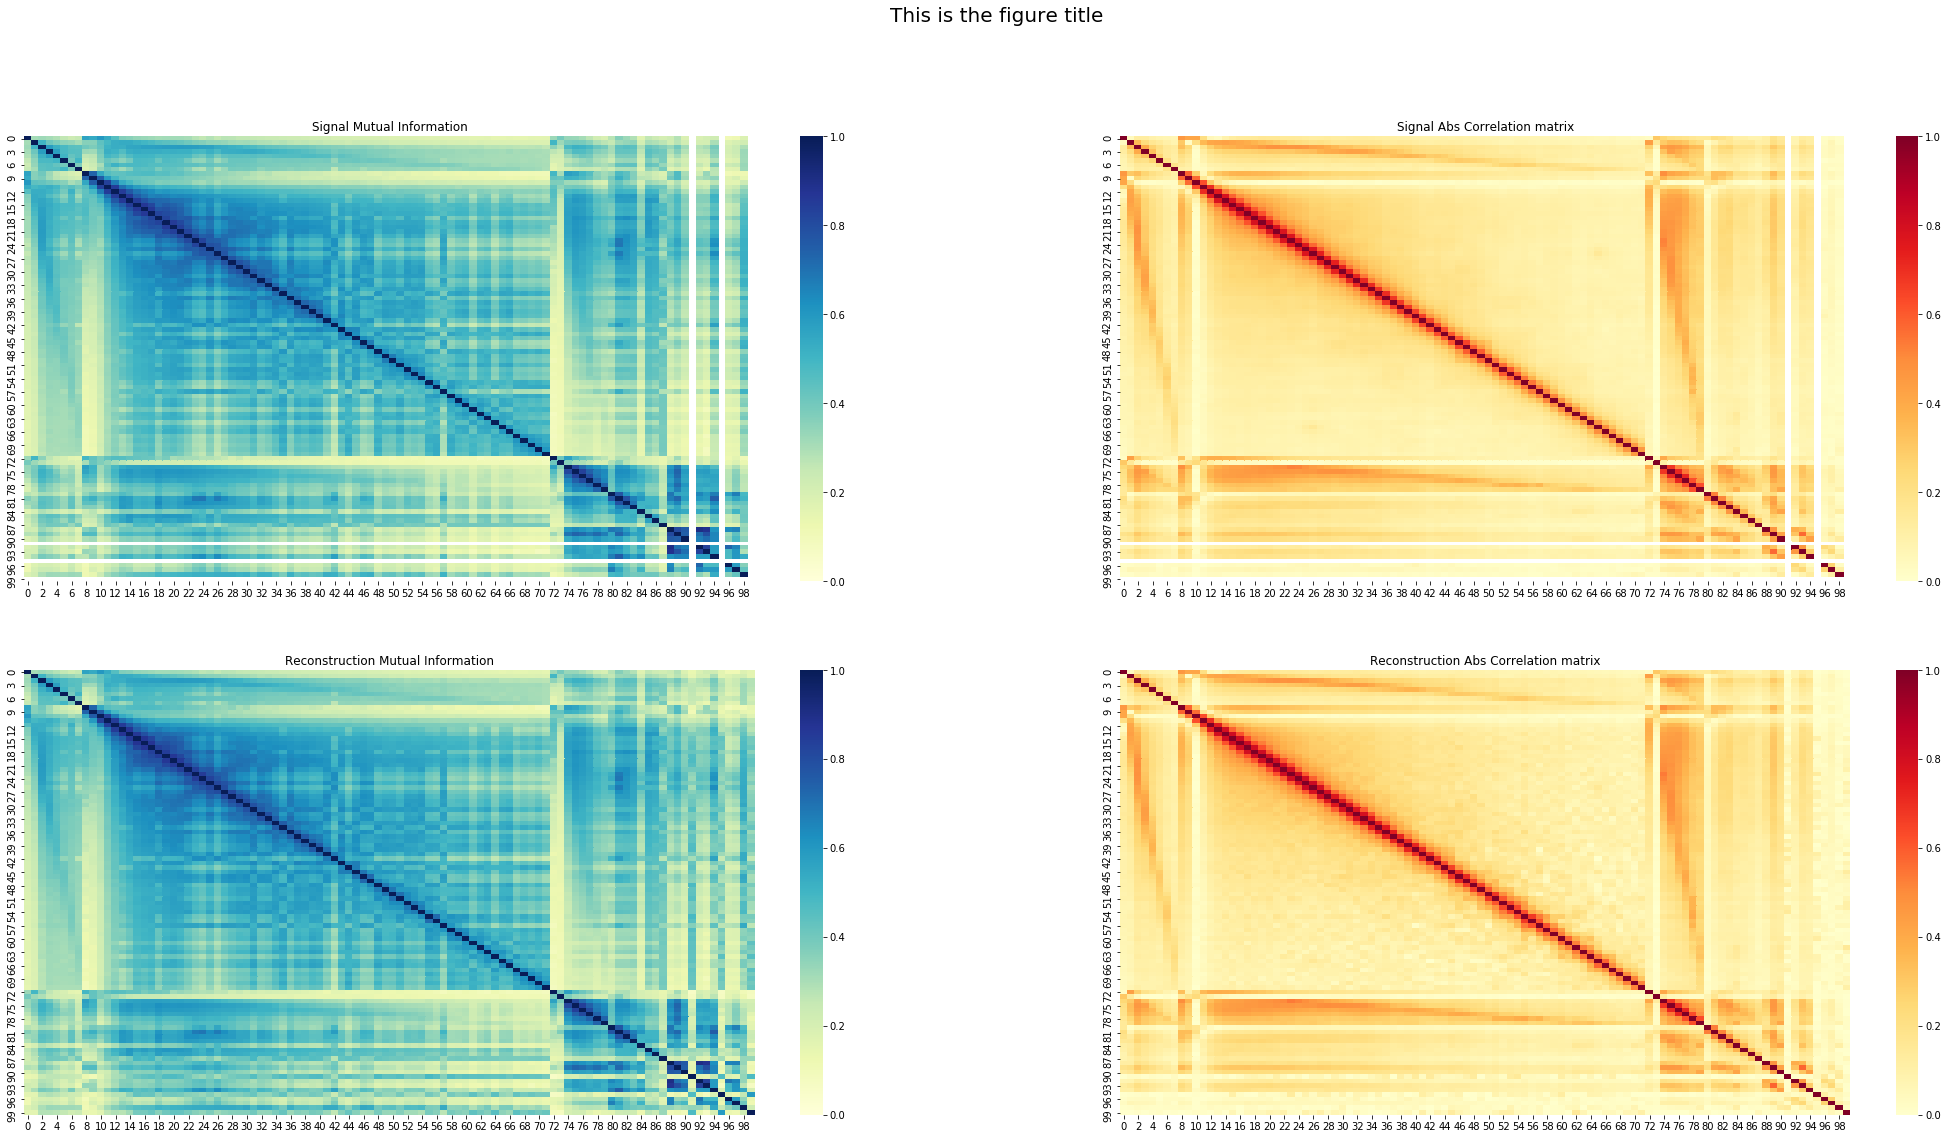

In [29]:
fig

In [30]:
fig.clf()

In [31]:
fig.close()

AttributeError: 'Figure' object has no attribute 'close'